In [1]:
import numpy as np
import joblib
import torch
import os
import geopandas as gpd
import sys

from scipy.ndimage import binary_erosion
from scipy.spatial.distance import cdist

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# Adjust the path to your project root directory where 'models' folder is located
project_root = os.path.abspath('../../../')  # or the relative path to your root from the notebook folder

if project_root not in sys.path:
    sys.path.insert(0, project_root)

from src.models.cnn import CNN_AE
from src.optimizer import GPOptimizer, DeepGPOptimizer
from src.utils import *

In [3]:
states = gpd.read_file(f'{project_root}/data/massachusetts/s_08mr23.shp')
mass = states[states['NAME']=='Massachusetts']

xmin = -71.25+0.05
xmax = -69.75-0.05
ymin = 41.6+0.05
ymax = 42.8-0.05

In [4]:
latent_dim = 30
acquisition_function = 'LCB'
save_data = True
n_iter = 100
seed = 0

In [5]:
grid_x = np.load(f'{project_root}/data/fvcom/grid_x.npy')
grid_y = np.load(f'{project_root}/data/fvcom/grid_y.npy')
grid_x_m, grid_y_m = sp_proj('forward', grid_x, grid_y,  'm')

t = np.load(f'{project_root}/data/fvcom/t.npy')
u = np.load(f'{project_root}/data/fvcom/u_interp.npy')
v = np.load(f'{project_root}/data/fvcom/v_interp.npy')

mask = np.isnan(u[0,:,:])

nt, ngrid, _ = u.shape

u_fill, v_fill = u.copy(), v.copy()
u_fill[:, mask] = 0
v_fill[:, mask] = 0

In [6]:
dt = 3600
ndays = 0.75
T = ndays*24*60*60
dts = [dt for _ in range(int(T / dt))]
num_traj = 5

In [7]:
safe_mask = binary_erosion(~mask, structure=np.ones((12, 12)))  
yy, xx = np.where(safe_mask)
coords = np.array(list(zip(xx, yy)))

In [8]:
nsamples = 1000
delta = nt // nsamples
tsteps = [(i+1)*delta - 1 for i in range(nsamples)]

In [9]:
u_true = u[tsteps,:,:]
v_true = v[tsteps,:,:]

omega = vort_FVCOM(u_true, v_true, grid_x_m, grid_y_m)
psi = streamfunction_FVCOM(omega, grid_x_m, grid_y_m)

omega = omega*1e5

In [10]:
# Re-load trajectories from saved files for each tstep
np.random.seed(seed)

initial_conditions = [coords[np.random.randint(len(coords))]]
for _ in range(1, num_traj):
    min_dists = cdist(coords, np.array(initial_conditions)).min(axis=1)
    initial_conditions.append(coords[np.argmax(min_dists)])
initial_conditions = np.array(initial_conditions)

idx_str = f'x0_{"_".join(map(str, initial_conditions[:,0]))}_y0_{"_".join(map(str, initial_conditions[:,1]))}'

base_path = f'{project_root}/results/fvcom/bo/constant_traj/'
base_path = os.path.join(base_path, idx_str)

trajectories = {}
for tstep in tsteps:
    tstep_dir = os.path.join(base_path, str(tstep))
    if os.path.exists(tstep_dir):
        trajectories[tstep] = {}
        for traj_i in range(num_traj):
            traj_path = os.path.join(tstep_dir, f'traj_{traj_i}.npy')
            if os.path.exists(traj_path):
                trajectories[tstep][traj_i] = np.load(traj_path)
            else:
                print(f"Trajectory file {traj_path} does not exist.")
    else:
        print(f"Directory {tstep_dir} does not exist.")

In [11]:
nn = CNN_AE(latent_dim=latent_dim)
nn.load_state_dict(torch.load(f"{project_root}/src/models/checkpoints/fvcom/cnn_{latent_dim}_model.pth"))
nn.to(device)
D = nn.decode

data, nn_scaler = transform_data_for_AE(u,v)
latent_space = get_latent_space(nn, data)

latent_inputs = gaussian_kde(latent_space)

 /home/bchamp/anaconda3/envs/ocean-flow/lib/python3.8/site-packages/torch/nn/modules/conv.py:456: UserWarning:Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/envs/bld/conda-bld/pytorch-select_1719512383855/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)


In [12]:
optimizers = {}
for tstep in tsteps:
    optimizers[tstep] =  DeepGPOptimizer(trajectories[tstep], dts, trajectory_cost_function, D, latent_inputs, grid_x, grid_y, nn_scaler, device, acquisition_function, n_init=0, train_init=False)

In [13]:
load_data = True

tsteps_copy = tsteps.copy()

if load_data:
    subfolder = f'{acquisition_function}_{latent_dim}'

    for tstep in tsteps:
        tstep_path = os.path.join(base_path, str(tstep), subfolder)

        if not os.path.exists(tstep_path):
            print(f'Warning: {tstep_path} does not exist. Skipping...')
            tsteps_copy.remove(tstep)
            continue

        optimizer = optimizers[tstep]
        optimizer.X = np.load(os.path.join(tstep_path, 'X.npy'))
        optimizer.Y = np.load(os.path.join(tstep_path, 'Y.npy'))

        optimizer.scaler_gp_x = joblib.load(os.path.join(tstep_path, 'scaler_gp_x.joblib'))
        optimizer.scaler_gp_y = joblib.load(os.path.join(tstep_path, 'scaler_gp_y.joblib'))

tsteps = tsteps_copy

In [14]:
z_opt, u_opt, v_opt, w_opt, psi_opt, traj_opt = [], [], [], [], [], []
u_err, v_err, w_err, psi_err = [], [], [], []
for idx, tstep in enumerate(tsteps):
    optimizer = optimizers[tstep]

    k=1
    
    if k == 1:
        z_i, u_i, v_i, traj_i = optimizer.get_optimal()
        w_i = vort_FVCOM(u_i, v_i, grid_x_m, grid_y_m)
        psi_i = streamfunction_FVCOM(w_i, grid_x_m, grid_y_m)
        w_i = w_i*1e5
    else:
        _, _, _, traj_i = optimizer.get_top_k(k=k)
        u_i, v_i = optimizer.get_top_k_mean(k=k)


    u_opt.append(u_i)
    v_opt.append(v_i)
    w_opt.append(w_i)
    psi_opt.append(psi_i)
    traj_opt.append(traj_i)

    u_err.append(u_true[idx] - u_i)
    v_err.append(v_true[idx] - v_i)
    w_err.append(omega[idx] - w_i)
    psi_err.append(psi[idx] - psi_i)



 /home/bchamp/anaconda3/envs/ocean-flow/lib/python3.8/site-packages/torch/nn/modules/conv.py:456: UserWarning:Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/envs/bld/conda-bld/pytorch-select_1719512383855/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)


In [15]:
# Compute the average of absolute errors across all samples
avg_u_err = np.mean([np.abs(err) for err in u_err], axis=0)
avg_v_err = np.mean([np.abs(err) for err in v_err], axis=0)
avg_w_err = np.mean([np.abs(err) for err in w_err], axis=0)
avg_psi_err = np.mean([np.abs(err) for err in psi_err], axis=0)

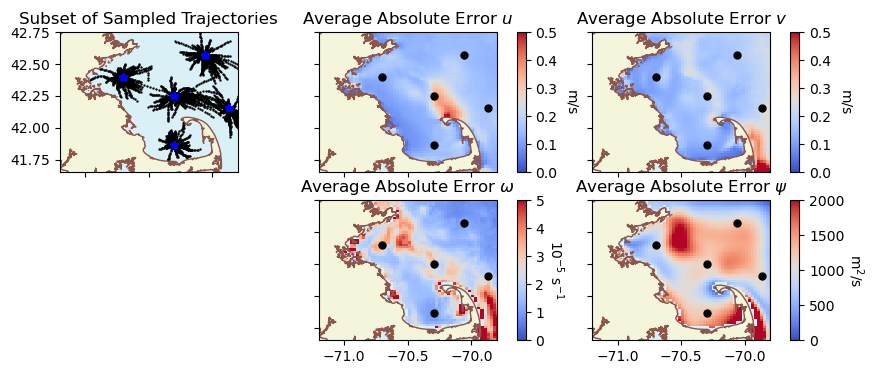

In [78]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

error_types = [
    {'name': 'u', 'units':'m/s', 'data': avg_u_err, 'vmin': 0, 'vmax': 0.5, 'title': 'Average Absolute Error $u$'},
    {'name': 'v', 'units':'m/s', 'data': avg_v_err, 'vmin': 0, 'vmax': 0.5, 'title': 'Average Absolute Error $v$'},
    {'name': '\omega', 'units':'$10^{-5}$ s$^{-1}$', 'data': avg_w_err, 'vmin': 0, 'vmax': 5, 'title': 'Average Absolute Error $\omega$'},
    {'name': '\psi', 'units':'m$^2$/s', 'data': avg_psi_err, 'vmin': 0, 'vmax': 2000, 'title': 'Average Absolute Error $\psi$'}
]

fig, axs = plt.subplots(2, 3, figsize=(10, 4), sharex=True, sharey=True)
main = axs

# Top-left: trajectories (no colorbar)
ax = main[0,0]
ax.set_facecolor(np.array([218, 240, 247]) / 255)
plt.sca(ax)
for tstep in tsteps[:50]:
    plot_trajectories_lines(trajectories[tstep])
mass.plot(ax=ax, color='beige', edgecolor='tab:brown')
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_aspect('equal')
ax.set_title('Subset of Sampled Trajectories')

# Map error fields to remaining axes
targets = {
    'u':        main[0,1],
    'v':        main[0,2],
    '\\omega':  main[1,1],
    '\\psi':    main[1,2],
}

for error in error_types:
    ax = targets[error['name']]
    ax.set_facecolor(np.array([218, 240, 247]) / 255)

    pcm = ax.pcolormesh(grid_x, grid_y, error['data'],
                        cmap='coolwarm', vmin=error['vmin'], vmax=error['vmax'])
    for idx in initial_conditions:
        ax.plot(grid_x[idx[1], idx[0]], grid_y[idx[1], idx[0]], 'ko', markersize=5)
    mass.plot(ax=ax, color='beige', edgecolor='tab:brown')
    
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_aspect('equal')
    ax.set_title(error['title'])

    # attach colorbar immediately next to plot
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.2)  # pad controls distance
    cb = fig.colorbar(pcm, cax=cax)
    cb.set_label(error['units'], rotation=270, labelpad=15)


axs[1,0].set_visible(False)
plt.savefig(f'{project_root}/figures/fvcom/bo/constant_traj_{tstep}_average_error_{acquisition_function}_{latent_dim}.png', dpi=300, bbox_inches='tight')
plt.show()


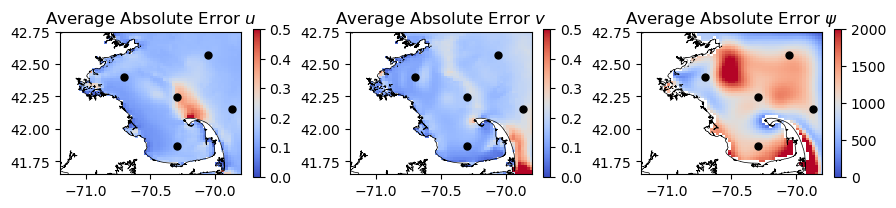

In [ ]:
# Define error types and their respective properties
error_types = [
    {'name': 'u', 'data': avg_u_err, 'vmin': 0, 'vmax': 0.5, 'title': 'Average Absolute Error $u$'},
    {'name': 'v', 'data': avg_v_err, 'vmin': 0, 'vmax': 0.5, 'title': 'Average Absolute Error $v$'},
    {'name': '\psi', 'data': avg_psi_err, 'vmin': 0, 'vmax': 2000, 'title': 'Average Absolute Error $\psi$'}
]

# Plot the average errors
plt.figure(figsize=(9, 2.2))
for i, error in enumerate(error_types):
    ax = plt.subplot(1, 3, i+1)
    plt.pcolormesh(grid_x, grid_y, error['data'], cmap='coolwarm', vmin=error['vmin'], vmax=error['vmax'])
    for idx in initial_conditions:
        plt.plot(grid_x[idx[1], idx[0]], grid_y[idx[1], idx[0]], 'ko', markersize=5)
    ax.set_aspect('equal')
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    plt.colorbar(shrink=0.8)
    plt.title(error['title'])
    mass.boundary.plot(ax=ax, color='black', linewidth=0.5) 
    ax.set_aspect('equal')



plt.tight_layout()
# plt.savefig(f'{project_root}/figure/fvcom/bo/FVCOM_constant_traj_average_error_{acquisition_function}_{latent_dim}.png', dpi=300, bbox_inches='tight')
plt.show()
